In [1]:
import pandas as pd
import bz2
from tqdm import tqdm
import json

# Zadaniye 1. Word2Vec and corpus analysis

## Load data

In [2]:
path = 'banki_responses.json.bz2'

def unpack_bz2(path, n_items=None):
    lines = []
    with bz2.open(path, 'rt') as bzinput:
        for i, cont in tqdm(enumerate(bzinput), total=n_items):
            tweets = json.loads(cont)
            lines.append(tweets)

            if len(lines) == n_items:
                break
    return pd.DataFrame(lines)

In [3]:
items = unpack_bz2(path, 10_000)

100%|██████████████████████████████████████████████████████████████████████████▉| 9999/10000 [00:05<00:00, 1689.02it/s]


In [4]:
items.tail(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
9997,г. Курск,False,Кредит: условия досрочного погашения,0,лицензия № 1326,subv,Альфа-Банк,2015-04-07 01:45:41,В феврале 2015 года взял потребительский креди...,1.0
9998,г. Москва,True,"Двойное списание по карте, жду возврата денег ...",1,лицензия № 1481,buh-outsourcing,Сбербанк России,2015-04-07 14:47:00,Добрый день! в ноябре 2014 года при оплате штр...,1.0
9999,г. Владивосток,False,Работа с претензиями,1,лицензия № 2766,ole76,ОТП Банк,2015-04-07 01:48:02,"Добрый день, 05 марта 2015 года мною в ваш кол...",NaN


## Preprocess texts

In [5]:
import pymorphy3
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import stopwords
morph = pymorphy3.MorphAnalyzer()
punkt = PunktSentenceTokenizer()
stops = stopwords.words('russian')

import re

In [6]:
def preprocesser(line):
    no_stops = filter(lambda x: x not in stops, re.findall(r'[а-яА-ЯёЁ]+', line.lower()))
    return [morph.parse(x)[0].normal_form for x in no_stops]

In [7]:
tokens = [preprocesser(line) for line in tqdm(items.text, total=len(items.text))]

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:02<00:00, 33.05it/s]


## Word2vec model tests

In [8]:
from gensim.models import Word2Vec

In [9]:
w2v_model = Word2Vec(tokens, min_count=5, window=5, epochs=15)

In [10]:
w2v_model.wv.most_similar(positive=['мошенник'])

[('преступник', 0.5781111717224121),
 ('вор', 0.5451207756996155),
 ('защитить', 0.5404499173164368),
 ('направо', 0.5253172516822815),
 ('взломать', 0.5184239149093628),
 ('жертва', 0.4940913915634155),
 ('украсть', 0.48818543553352356),
 ('чужой', 0.4793541431427002),
 ('злоумышленник', 0.4762876629829407),
 ('мошенничество', 0.4669113755226135)]

In [11]:
w2v_model.wv.most_similar(positive=['кредит', 'дом'])

[('автокредит', 0.6043991446495056),
 ('ипотека', 0.5733388662338257),
 ('жильё', 0.5369824767112732),
 ('машина', 0.5250198841094971),
 ('техника', 0.5146173238754272),
 ('автомобиль', 0.5135783553123474),
 ('ноутбук', 0.5119233727455139),
 ('мебель', 0.5051862597465515),
 ('холодильник', 0.5011734962463379),
 ('квартира', 0.4961666464805603)]

In [12]:
w2v_model.wv.most_similar(positive=['устройство', 'наличный', 'снять'])

[('банкомат', 0.7296071648597717),
 ('съесть', 0.6413177847862244),
 ('наличность', 0.6305314302444458),
 ('обналичивание', 0.602552592754364),
 ('орс', 0.599166989326477),
 ('снятие', 0.5868023037910461),
 ('обналичить', 0.5774514675140381),
 ('зажевать', 0.5756831765174866),
 ('снимать', 0.5688515305519104),
 ('выскакивать', 0.5642754435539246)]

In [13]:
w2v_model.wv.most_similar(positive=['устройство', "офис"], negative=['помощь', 'сотрудник'])

[('зона', 0.4363991916179657),
 ('таиланд', 0.4224472641944885),
 ('успевать', 0.4124605059623718),
 ('веселие', 0.4092111587524414),
 ('завод', 0.40630969405174255),
 ('банкомат', 0.4045265018939972),
 ('супермаркет', 0.4016896188259125),
 ('боль', 0.40100541710853577),
 ('орс', 0.3958878219127655),
 ('внутри', 0.39396148920059204)]

In [14]:
w2v_model.wv.most_similar(positive=["звонок", "постоянно", "реклама"], negative=["удобно"])

[('ежедневно', 0.6341622471809387),
 ('угроза', 0.5583564043045044),
 ('автоинформатор', 0.557292640209198),
 ('автоответчик', 0.5533663034439087),
 ('спам', 0.5290499925613403),
 ('начинать', 0.5102061033248901),
 ('терроризировать', 0.5086888074874878),
 ('обзванивать', 0.5058236122131348),
 ('ночь', 0.5001330375671387),
 ('угрожать', 0.49288445711135864)]

## Visualization by banks

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

### TSNE

In [16]:
from sklearn.manifold import TSNE
import numpy as np
from collections import Counter

In [17]:
from sklearn.cluster import AgglomerativeClustering

In [18]:
count = Counter()

for line in tqdm(tokens, total=len(tokens)):
    if not isinstance(line, list):
        line = [line]
    count.update(line)

top100words = np.array(count.most_common(100))[:, 0]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 53201.69it/s]


In [19]:
tsne = TSNE(2, perplexity=3, random_state=15)
arr = np.array([w2v_model.wv[word] for word in top100words])

tsne_arr = tsne.fit_transform(arr)
xs = tsne_arr[:, 0]
ys = tsne_arr[:, 1]

In [42]:
cluster_model = AgglomerativeClustering(n_clusters=None, distance_threshold=25)
clusters = cluster_model.fit_predict(tsne_arr)

df = pd.DataFrame({'x':xs, 'y':ys, 'word':top100words, 'cluster':clusters})

cluster_words = [" - ".join(elem[-1].word.tolist()) for elem in df.groupby('cluster')]

In [52]:
for clust, clust_words in zip(sorted(df.cluster.unique()), cluster_words):
    df.loc[df[df['cluster'] == clust].index, 'cluster'] = clust_words

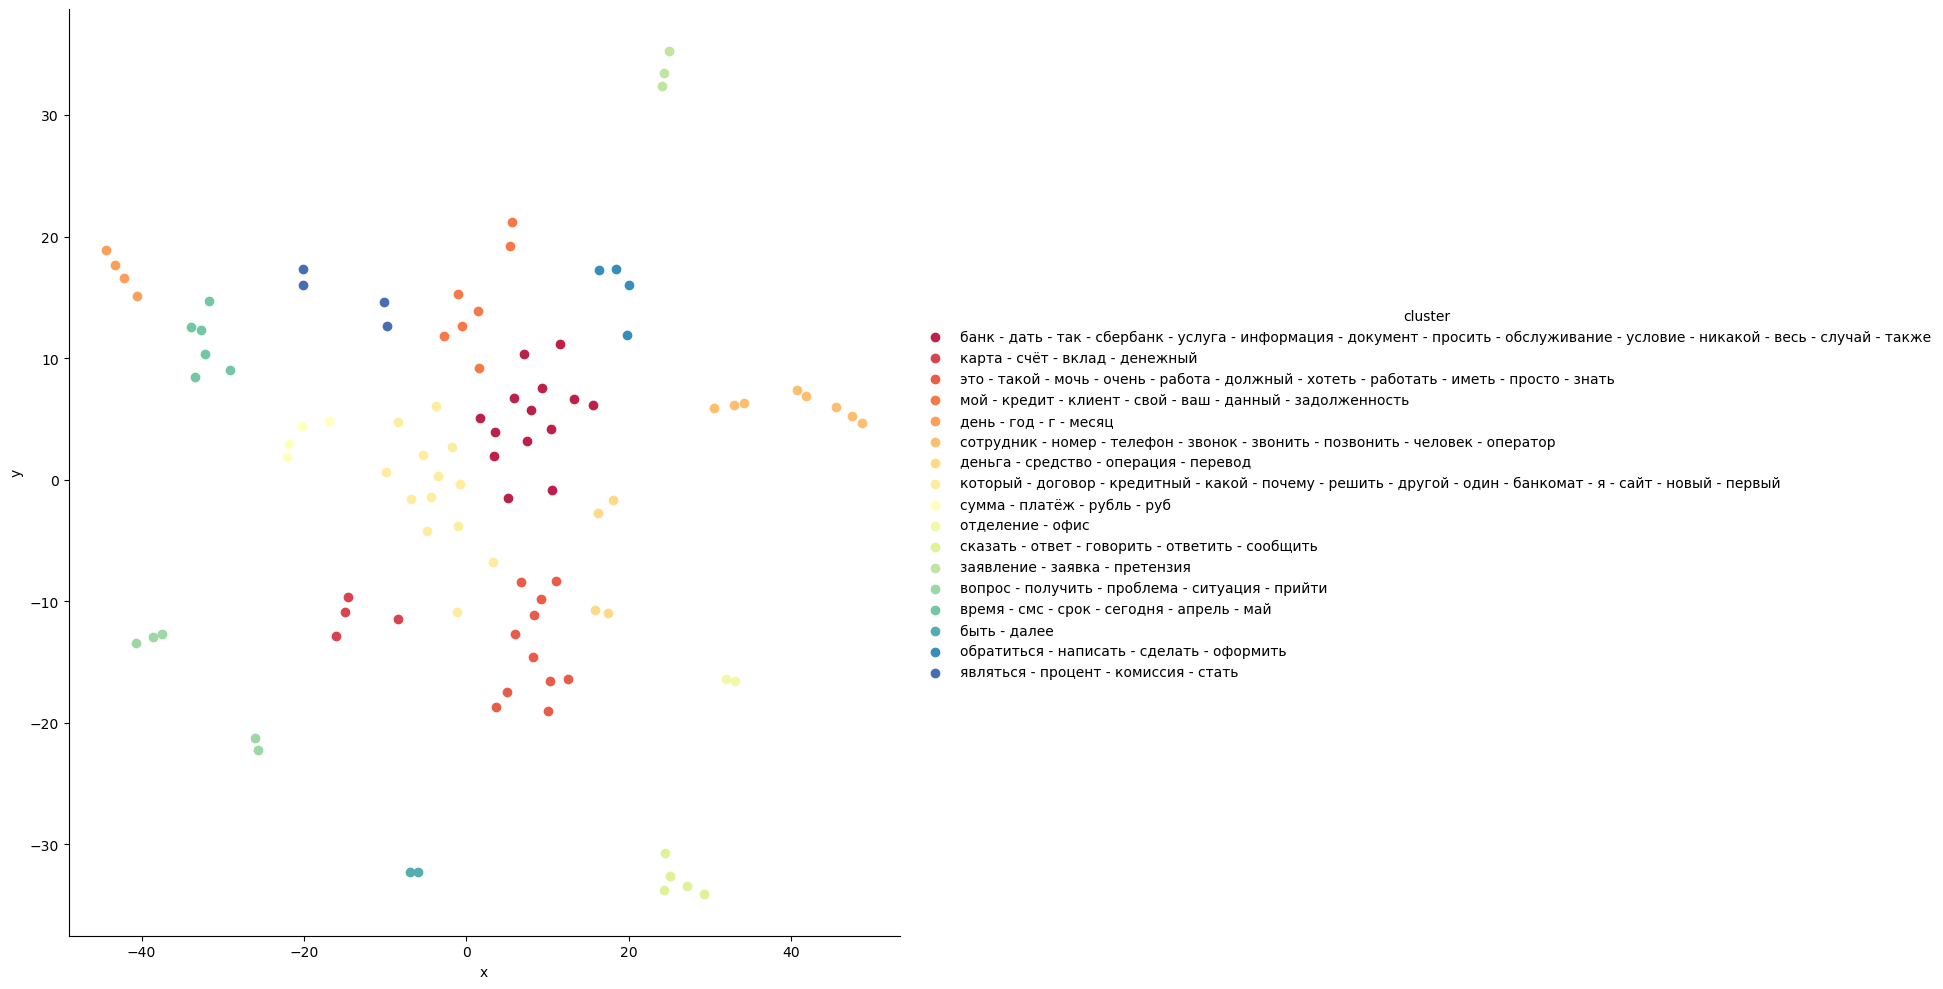

In [54]:
sns.FacetGrid(df, hue='cluster', height=10, palette='Spectral').map(plt.scatter, 'x', 'y').add_legend()
plt.show()

### Word sentiment handmade graphical map

In [22]:
from sklearn.decomposition import PCA

In [23]:
all_keys = w2v_model.wv.key_to_index.keys()
dict_keys = w2v_model.wv

In [24]:
filtrer_ = lambda x: re.findall(r'[а-яА-ЯёЁ]+', re.sub(r'(\Wбанк\W)|(\Wкредитный\W)|(\Wроссии\W)', '', x.lower()))[0]

banks = list(map(filtrer_, items.bank_name.unique()))
bank_names = list(filter(lambda x: x in all_keys, banks))

In [25]:
horosho = dict_keys[dict_keys.key_to_index['плохой']] 
ploho = dict_keys[dict_keys.key_to_index['хороший']]

medlenno = dict_keys[dict_keys.key_to_index['медленный']] 
bystro = dict_keys[dict_keys.key_to_index['быстрый']]

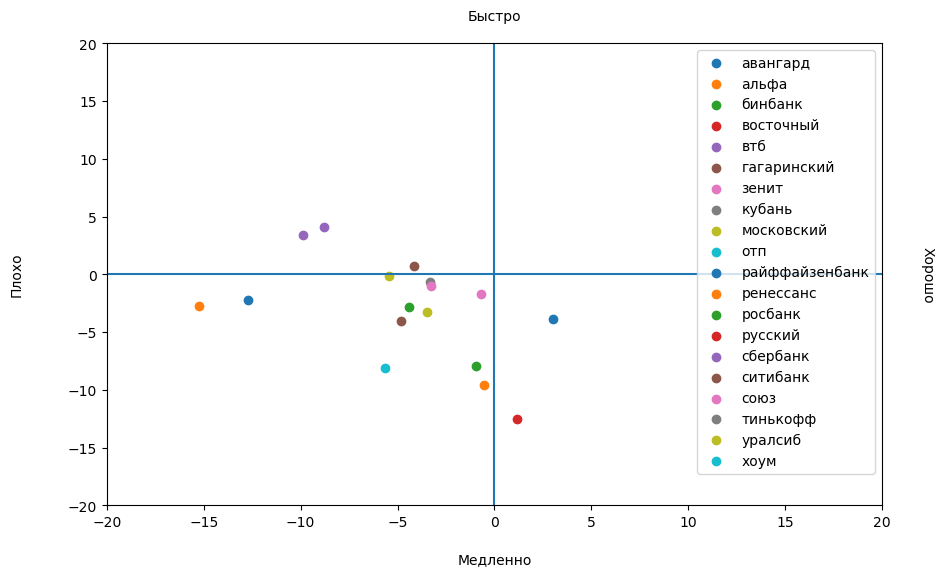

In [26]:
plt.figure(figsize=(10, 6))

plt.axhline(0)
plt.axvline(0)

for bank in sorted(bank_names[:20]):
    bank_vector = dict_keys[dict_keys.key_to_index[bank]]
    x = bank_vector @ (horosho - ploho)
    y = bank_vector @ (bystro - medlenno)
    plt.scatter([x], [y], label=bank)

plt.text(22, 0, 'Хорошо', rotation=270, va='center')
plt.text(-25, 0, 'Плохо', rotation=90, va='center')
plt.text(0, 22, 'Быстро', rotation=0, ha='center')
plt.text(0, -25, 'Медленно', rotation=0, ha='center')

plt.xlim([-20, 20])
plt.ylim([-20, 20])

plt.legend()
plt.show()

Проверочка

In [27]:
items.rating_grade.value_counts()

1.0    3734
5.0    1014
2.0     790
3.0     324
4.0     158
Name: rating_grade, dtype: int64

Ну да, похоже на правду

# Zadaniye 2. Label propagation model

In [57]:
from sklearn.semi_supervised import LabelSpreading

In [143]:
LP = LabelSpreading()

In [144]:
positive_words = ["быстрый", "хороший", "качественный", "ответственный", "приятный", "помощь", "поддержка"]
negative_words = ["преступление", "мошенничество", "угроза", "спам", "безответственный", "бесполезно", "медленный"]

In [199]:
all_words = np.array(list(w2v_model.wv.key_to_index.keys()))

labels = np.array([1 if i in positive_words else 2 if i in negative_words else -1 for i in all_words])

In [180]:
train_indexes = np.where( (labels==1) | (labels==2) )
test_indexes = np.where(labels == -1)

In [204]:
X_train = w2v_model.wv.vectors[train_indexes]
X_test = w2v_model.wv.vectors[test_indexes]

y_train = labels[train_indexes]
y_test = labels[test_indexes]

test_words = all_words[test_indexes]

In [191]:
LP.fit(X_train, y_train)

yhat = LP.predict(X_test)

C:\Users\Igor\AppData\Local\Programs\Python\conda\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Lets see at our results

In [192]:
pd.Series(yhat).value_counts()

1    7671
2    1184
dtype: int64

Model classified 7671 words as positive and 1184 as negative

Examples of positively classified words

In [207]:
test_words[np.where(yhat==2)][:10]

array(['подчёркивать', 'нерадивый', 'глобальный', 'стыд', 'полно',
       'бабка', 'случайность', 'коснуться', 'опускать', 'респект'],
      dtype='<U24')

In [208]:
test_words[np.where(yhat==1)][:10]

array(['банк', 'карта', 'это', 'мой', 'кредит', 'день', 'сотрудник',
       'деньга', 'который', 'клиент'], dtype='<U24')

#### Conclusion:

- Алгоритм Word2Vec сработал довольно сносно:
  - не самые трудные интуитивные тесты по семантической близости он прошёл
  - маппинг слов в большинстве случаев имеет смысл (напр. кластер "день-год-г-месяц" или "отделение-офис" или "деньга-средство-операция-перевод" довольно репрезентативны)
  - разметка в разрезе сентименты/банки похожа на правду (взвешенные маппинги группируются на 2, 3 и 4 четвертях двумерной плоскости (негативных), тогда как и негативных отзывов в разы больше)
- Кажется, для полноценного label spreading'а не хватает трейновых данных - для датасета из более 8к слов всего 14 меток - это довольно маловато, отсюда модель так слабо тренируется. Некоторые моменты похожи на правду, но всё же слабо